In [1]:
import numpy as np

In [2]:
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from toy_datasets import ToyDatasets

In [43]:
class Stage3Algorithm():
  def __init__(self, num_elements, order):
    self.num_elements = num_elements
    self.order = order
    self.A = None

  def objective(self, A, x, y):
    A = A.reshape((self.order, self.order))
    result = np.square(np.linalg.norm(y - A @ x, 2))
    return result.flatten()
  
  def hankelise(self, x):
    """
    A function to take in an input vector of size 1x(n-1) and construct a Hankel matrix
    from it with a specified order (essentially specified number of rows). 
    """

    hankel_matrix = np.zeros((self.order, x.shape[1] - self.order + 1))
    for i in range(self.order):
      hankel_matrix[i, :] = x[0, i:i+x.shape[1]-self.order+1]
    return hankel_matrix
  
  def fit(self, x, y):
    x, y = self.hankelise(x), self.hankelise(y)
    for i in range(len(x)):
      # raise each row to a power except for last row of y
      x[i, :] = np.power(x[i, :], i+1)
      if i != len(x) - 1:
        y[i, :] = np.power(y[i, :], i+2)

    A_initial_guess = np.zeros((self.order, self.order))
    for i in range(self.order-1):
      A_initial_guess[i, i+1] = 1
    # initial guess for A1, A2, ..., Ad are 0
    A = least_squares(self.objective, A_initial_guess.flatten(), args=(x, y))
    A = A.x.reshape((self.order, self.order))[-1]
    self.A = A

  def predict(self, x):
    y_predicted = []
    for i in range(self.num_elements - self.order):
      x_subset = x.flatten()[i:i+self.order]
      for j in range(len(x_subset)):
        x_subset[j] = x_subset[j] ** (j+1)
      y_predicted.append(np.dot(x_subset, self.A).flatten()[0])
    return y_predicted
  
  def evaluate(self, y, y_predicted):
    return np.sqrt(1/len(y) * np.sum(np.square(y - y_predicted)))

In [44]:
num_elements = 100
toy_datasets = ToyDatasets(num_elements=num_elements)

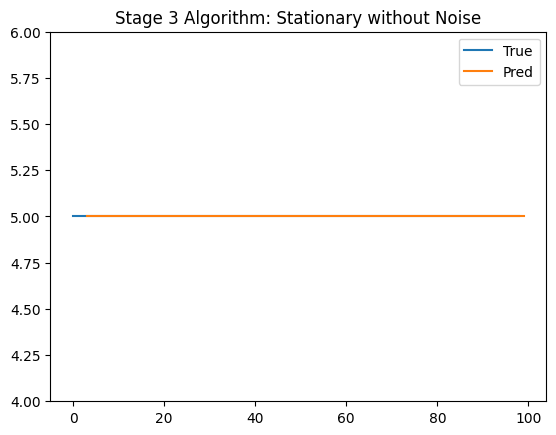

RMSE:  7.856508533521378e-06


In [46]:
np.random.seed(0)
order = 3
toy_data = toy_datasets.stationary_without_noise(offset=5).reshape(-1, 1).T
x, y = toy_data[:, :-1], toy_data[:, 1:]
alg = Stage3Algorithm(num_elements=num_elements, order=order)
alg.fit(x, y)
plt.plot(y.flatten(), label="True")
y_predicted = alg.predict(x)
plt.plot(range(order, num_elements), y_predicted, label="Pred")
plt.title("Stage 3 Algorithm: Stationary without Noise")
plt.legend()
plt.ylim(4, 6)
plt.show()
accuracy = alg.evaluate(y[0, order-1:], y_predicted)
print("RMSE: ", accuracy)

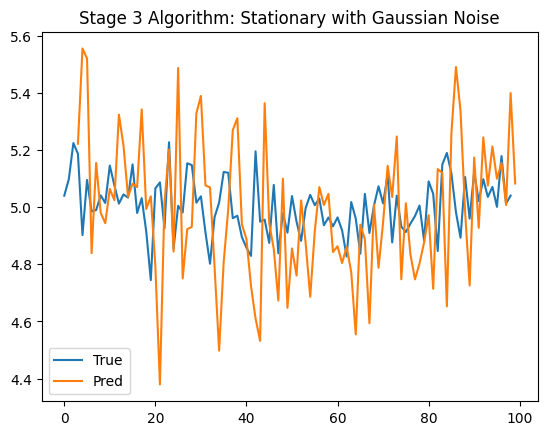

RMSE:  0.2514182055639529


In [48]:
np.random.seed(0)
order = 3
toy_data = toy_datasets.stationary_with_gaussian_noise(offset=5).reshape(-1, 1).T
x, y = toy_data[:, :-1], toy_data[:, 1:]
alg = Stage3Algorithm(num_elements=num_elements, order=order)
alg.fit(x, y)
plt.plot(y.flatten(), label="True")
y_predicted = alg.predict(x)
plt.plot(range(order, num_elements), y_predicted, label="Pred")
plt.title("Stage 3 Algorithm: Stationary with Gaussian Noise")
plt.legend()
plt.show()
accuracy = alg.evaluate(y[0, order-1:], y_predicted)
print("RMSE: ", accuracy)

In [51]:
alg.A

array([ 0.00064351,  0.0023699 ,  0.00788128,  0.01162095, -0.0011934 ])

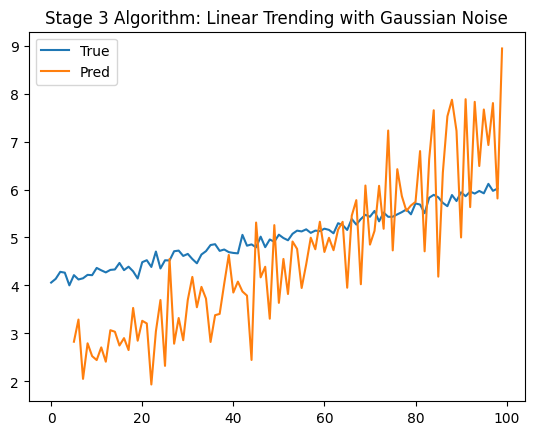

RMSE:  1.2197238500284706


In [50]:
np.random.seed(0)
order = 5
toy_data = toy_datasets.linear_trending_with_gaussian_noise(offset=5).reshape(-1, 1).T
x, y = toy_data[:, :-1], toy_data[:, 1:]
alg = Stage3Algorithm(num_elements=num_elements, order=order)
alg.fit(x, y)
plt.plot(y.flatten(), label="True")
y_predicted = alg.predict(x)
plt.plot(range(order, num_elements), y_predicted, label="Pred")
plt.title("Stage 3 Algorithm: Linear Trending with Gaussian Noise")
plt.legend()
plt.show()
accuracy = alg.evaluate(y[0, order-1:], y_predicted)
print("RMSE: ", accuracy)